In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import math
import time
import os

In [3]:
class Network(nn.Module):
    def __init__(self,num_input=2,layers=[64, 64, 64],num_output=3):
        super(Network,self).__init__()
        self.input_layer=nn.Linear(num_input,layers[0])
        self.hidden_layer=nn.ModuleList()
        for i in range(len(layers)-1):
            self.hidden_layer.append(nn.Linear(layers[i],layers[i+1]))
        self.output_layer=nn.Linear(layers[-1],num_output)
    def forward(self,out):
        out=torch.tanh(self.input_layer(out))
        for layer in self.hidden_layer:
            out=torch.tanh(layer(out))
        out=self.output_layer(out)
        return out

In [38]:
class Pinns:
    def __init__(self):
        # Transfer to GPU if it is possible
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.network = Network().to(self.device)

        # Assumptions
        self.rho=1.0
        self.nu=0.001
        self.u0=1.0

        # Domain_Definition
        dx=0.01
        dy=0.01
        self.x=torch.arange(0,1+dx,dx)
        self.y=torch.arange(0,1+dy,dy)
        self.X = torch.stack(torch.meshgrid(self.x,self.y)).reshape(2,-1).T
        self.X.requires_grad = True

        # Boundary_condition_input
        dx_b=0.001
        dy_b=0.001
        self.x_b = torch.arange(0,1+dx_b,dx_b)
        self.y_b = torch.arange(0,1+dy_b,dy_b)
        self.rw = torch.stack(torch.meshgrid(self.x_b[-1],self.y_b)).reshape(2,-1).T
        self.lw = torch.stack(torch.meshgrid(self.x_b[0],self.y_b)).reshape(2,-1).T
        self.uw = torch.stack(torch.meshgrid(self.x_b,self.y_b[-1])).reshape(2,-1).T
        self.dw = torch.stack(torch.meshgrid(self.x_b,self.y_b[0])).reshape(2,-1).T
        self.X_train = torch.cat([self.rw, self.lw, self.uw,  self.dw])

        # Boundary_condition_output
        self.uv_rw = torch.stack(torch.meshgrid(self.x_b[0],torch.zeros_like(self.y_b))).reshape(2,-1).T
        self.uv_lw = torch.stack(torch.meshgrid(self.x_b[0],torch.zeros_like(self.y_b))).reshape(2,-1).T
        self.uv_uw = torch.stack(torch.meshgrid(self.u0*self.x_b[-1],torch.zeros_like(self.y_b))).reshape(2,-1).T
        self.uv_dw = torch.stack(torch.meshgrid(self.x_b[0],torch.zeros_like(self.y_b))).reshape(2,-1).T
        self.uv_train = torch.cat([self.uv_rw, self.uv_lw, self.uv_uw,  self.uv_dw])

        # Transfer tensor to GPU
        self.uv_train = self.uv_train.to(self.device)
        self.X_train = self.X_train.to(self.device)
        self.X = self.X.to(self.device)

        # Error criterion Definition
        self.criterion = nn.MSELoss()

        # Optimizer setting
        self.adam = torch.optim.Adam(self.network.parameters(), lr=1e-4)
        # , lr=1e-4
        # Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
        self.network.parameters(),
            lr=0.01,
            max_iter = 2000,
            max_eval = 2000,
            history_size = 50,
            tolerance_grad = 1e-8,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )
        self.loss_history = []
    #compute derivations
    def gradient(self,input,index):
        output = torch.autograd.grad(
            input,
            self.X,
            grad_outputs=torch.ones_like(input),
            create_graph=True,
            retain_graph=True
        )[0]
        return output[:,index]

    def loss_f(self):
        #Restart Optimizer
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        #output of NN for boundary
        self.uv_P_b = self.network(self.X_train)
        self.u_P_b = self.uv_P_b[:,0]
        self.v_P_b = self.uv_P_b[:,1]

        #loss data definition
        self.loss_data = self.criterion(self.u_P_b,self.uv_train[:,0])+self.criterion(self.v_P_b,self.uv_train[:,1])

        #output of NN
        self.uvp_P = self.network(self.X)
        self.u_P = self.uvp_P[:,0]
        self.v_P = self.uvp_P[:,1]
        self.p_P = self.uvp_P[:,2]

        #compute derivations
        self.du_dx = self.gradient(self.u_P,0)
        self.du_dy = self.gradient(self.u_P,1)
        self.du_dxx= self.gradient(self.du_dx,0)
        self.du_dyy= self.gradient(self.du_dy,1)
        self.dv_dx = self.gradient(self.v_P,0)
        self.dv_dy = self.gradient(self.v_P,1)
        self.dv_dxx= self.gradient(self.dv_dx,0)
        self.dv_dyy= self.gradient(self.dv_dy,1)
        self.dp_dx = self.gradient(self.p_P,0)
        self.dp_dy = self.gradient(self.p_P,1)

        # compute equation loss
        self.con_equ=self.du_dx+self.dv_dy
        self.u_eqn = self.uvp_P[:,0]*self.du_dx + self.uvp_P[:,1]*self.du_dy + self.dp_dx/self.rho - self.nu*(self.du_dxx + self.du_dyy)
        self.v_eqn = self.uvp_P[:,0]*self.dv_dx + self.uvp_P[:,1]*self.dv_dy + self.dp_dy/self.rho - self.nu*(self.dv_dxx + self.dv_dyy)

        #loss PDE definition
        self.loss_pde = self.criterion(self.con_equ,torch.zeros_like(self.con_equ))+self.criterion(self.u_eqn,torch.zeros_like(self.u_eqn))+\
                        self.criterion(self.v_eqn,torch.zeros_like(self.v_eqn))

        #loss function definition
        lambda_bc = 1.0
        lambda_pde = 1.0
        self.loss = lambda_bc * self.loss_data + lambda_pde * self.loss_pde
        self.loss.backward()
        return self.loss
    def train(self, num_epochs=1):
        self.network.train()
        for i in range(num_epochs):
            loss = self.loss_f()
            self.loss_history.append(loss.item())
            if i % 10 == 0:
                print(f"Iteration {i}, Loss: {self.loss.item():.6f}")
            if i % 1000 == 0:
                torch.save(self.network.state_dict(), r'C:/Users/hossein/Result/Cavity Ra=1000/1-PINNs/model')
            self.adam.step(self.loss_f)
        self.optimizer.step(self.loss_f)
    def plot(self):
        import os
        os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
        self.network.eval()
        with torch.no_grad():
            self.u = self.uvp_P[:,0].reshape(len(self.x), len(self.y)).cpu().numpy().T
            self.v = self.uvp_P[:,1].reshape(len(self.x), len(self.y)).cpu().numpy().T
            self.p = self.uvp_P[:,2].reshape(len(self.x), len(self.y)).cpu().numpy().T

        plt.rcParams.update({
            "font.family": "Times New Roman",
            "font.style": "italic"
        })

        plt.figure(figsize=(6, 5))
        contour1 = plt.contourf(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.u, levels=50, cmap="jet")
        cbar = plt.colorbar(contour1)
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.3f"))      
        plt.xlabel("X ", fontsize=13)
        plt.ylabel("Y ", fontsize=13)
        plt.title("u velocity", fontsize=13)
        plt.savefig("C:/Users/hossein/Result/Cavity Ra=1000/1-PINNs/u_plot.png", dpi=300)
        plt.show()
        plt.close()

        plt.figure(figsize=(6, 5))
        contour2 = plt.contourf(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.v, levels=50, cmap="jet")
        cbar = plt.colorbar(contour2)
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.3f"))
        plt.xlabel("X ", fontsize=13)
        plt.ylabel("Y ", fontsize=13)
        plt.title("v velocity", fontsize=13)
        plt.savefig("C:/Users/hossein/Result/Cavity Ra=1000/1-PINNs/v_plot.png", dpi=300)
        plt.show()
        plt.close()

        plt.figure(figsize=(6, 5))
        contour3 = plt.contourf(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.p, levels=50, cmap="jet")
        cbar = plt.colorbar(contour3)
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.3f"))
        plt.xlabel("X", fontsize=13)
        plt.ylabel("Y", fontsize=13)
        plt.title("Pressure", fontsize=13)
        plt.savefig("C:/Users/hossein/Result/Cavity Ra=1000/1-PINNs/pressure_plot.png", dpi=300)
        plt.show()
        plt.close()

        plt.figure(figsize=(5, 5))
        plt.streamplot(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.u, self.v, color='red', cmap='autumn', linewidth=0.5, density=2.0, arrowsize=0)
        plt.xlabel("X", fontsize=13)
        plt.ylabel("Y", fontsize=13)
        plt.title("streamline", fontsize=13)
        plt.savefig("C:/Users/hossein/Result/Cavity Ra=1000/1-PINNs/streamline_plot.png", dpi=300)
        plt.show()
        plt.close()

    def plot_loss(self):
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 5))
        plt.plot(self.loss_history, label='Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Function History')
        plt.yscale("log")
        plt.grid(True)
        plt.legend()
        plt.show()
        df = pd.DataFrame({"loss": self.loss_history})
        df.to_csv("C:/Users/hossein/Result/Cavity Ra=1000/1-PINNs/loss_history5.csv", index=False)

Iteration 0, Loss: 0.000664
Iteration 10, Loss: 0.006655
Iteration 20, Loss: 0.001798
Iteration 30, Loss: 0.001915
Iteration 40, Loss: 0.000843
Iteration 50, Loss: 0.000712
Iteration 60, Loss: 0.000654
Iteration 70, Loss: 0.000640
Iteration 80, Loss: 0.000631
Iteration 90, Loss: 0.000628
Iteration 100, Loss: 0.000627
Iteration 110, Loss: 0.000625
Iteration 120, Loss: 0.000625
Iteration 130, Loss: 0.000624
Iteration 140, Loss: 0.000624
Iteration 150, Loss: 0.000624
Iteration 160, Loss: 0.000624
Iteration 170, Loss: 0.000623
Iteration 180, Loss: 0.000623
Iteration 190, Loss: 0.000623
Iteration 200, Loss: 0.000623
Iteration 210, Loss: 0.000623
Iteration 220, Loss: 0.000623
Iteration 230, Loss: 0.000623
Iteration 240, Loss: 0.000623
Iteration 250, Loss: 0.000623
Iteration 260, Loss: 0.000623
Iteration 270, Loss: 0.000623
Iteration 280, Loss: 0.000623
Iteration 290, Loss: 0.000623
Iteration 300, Loss: 0.000623
Iteration 310, Loss: 0.000623
Iteration 320, Loss: 0.000622
Iteration 330, Loss: 

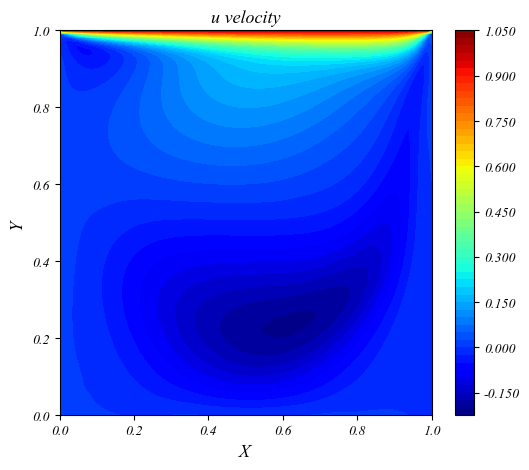

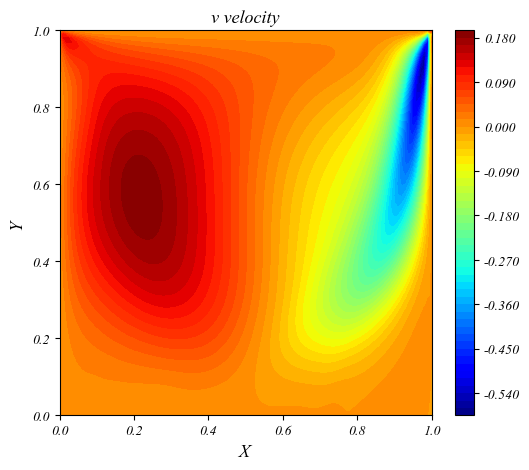

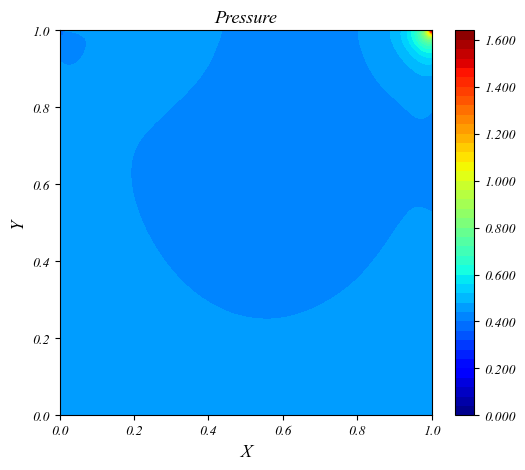

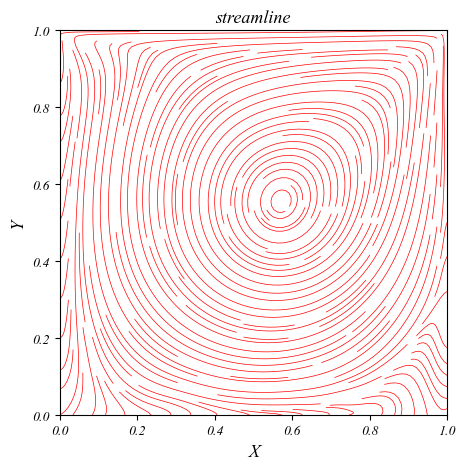

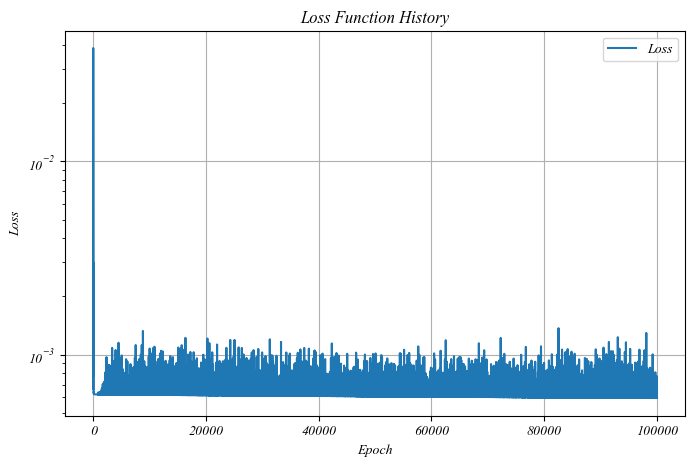

In [39]:
net = Pinns()
net.network.load_state_dict(torch.load(r'C:/Users/hossein/Result/Cavity Ra=1000/1-PINNs/model'))
net.train(num_epochs=100000)
net.plot()
net.plot_loss()

In [40]:
# Given validation data
x_validation = np.array([1, 8, 9, 10, 14, 23, 37, 59, 65, 80, 95, 110, 123, 124, 125, 126, 129])/129
u_validation2 = np.array([0, -0.03717, -0.04192, -0.04775, -0.06434, -0.1015, -0.15662, -0.21090,
                          -0.20581, -0.13641, 0.00332, 0.23151, 0.68717, 0.73722, 0.78871, 0.84123, 1])

y_validation = np.array([1, 9, 10, 11, 13, 21, 30, 31, 65, 104, 111, 117, 122, 123, 124, 125, 129])/129
v_validation2 = np.array([0, 0.09233, 0.10091, 0.10890, 0.12317, 0.16077, 0.17507, 0.17527, 0.05454,
                          -0.24533, -0.22445, -0.16914, -0.10313, -0.08864, -0.07391, -0.05906, 0])

In [41]:
# Given validation data for R=1000
x_validation = np.array([1, 8, 9, 10, 14, 23, 37, 59, 65, 80, 95, 110, 123, 124, 125, 126, 129])/129
u_validation2 = np.array([0, -0.18109, -0.20196, -0.22220, -0.29730, -0.38289, -0.27805, -0.10648,
                          -0.06080, 0.05702, 0.18719, 0.33304, 0.46604, 0.51117, 0.57492, 0.65928, 1])

y_validation = np.array([1, 9, 10, 11, 13, 21, 30, 31, 65, 104, 111, 117, 122, 123, 124, 125, 129])/129
v_validation2 = np.array([0, 0.27485, 0.29012, 0.30353, 0.32627, 0.37095, 0.33075, 0.32235, 0.02526,
                          -0.31966, -0.42665, -0.51550, -0.39188, -0.33714, -0.27669, -0.21388, 0])

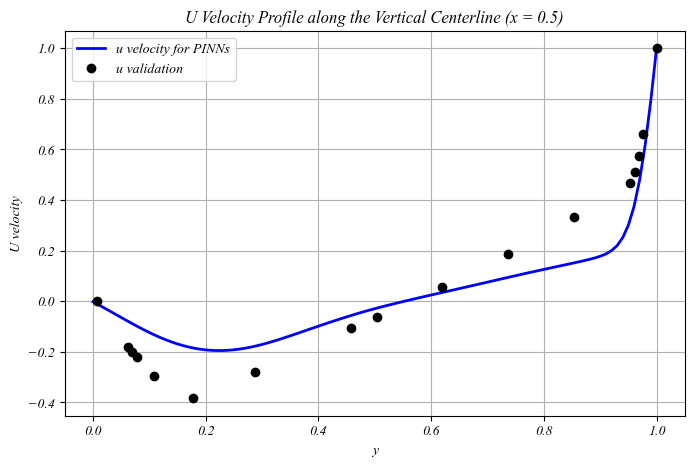

In [42]:
u=net.uvp_P[:,0]
u=u.reshape(len(net.x), len(net.y)).detach().cpu().numpy()
plt.figure(figsize=(8, 5))
x=torch.arange(0,1+1/128,1/128)
plt.plot(net.x, u[51,:], 'b-', linewidth=2, label='u velocity for PINNs')
plt.plot(x_validation, u_validation2, 'ko', label="u validation", markersize=6, linewidth=2)
plt.xlabel("y")
plt.ylabel("U velocity")
plt.title("U Velocity Profile along the Vertical Centerline (x = 0.5)")
plt.legend()
plt.grid(True)
plt.show()

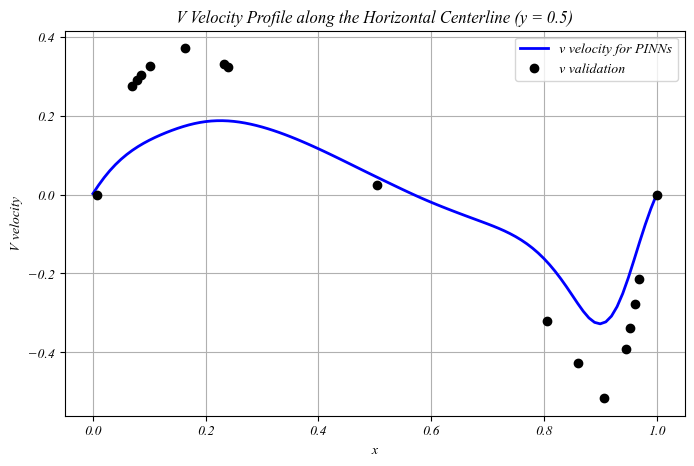

In [43]:
v=net.uvp_P[:,1]
v=v.reshape(len(net.x), len(net.y)).detach().cpu().numpy()
plt.figure(figsize=(8, 5))
x=torch.arange(0,1+1/128,1/128)
plt.plot(net.x, v[:,51], 'b-', linewidth=2, label='v velocity for PINNs')
plt.plot(y_validation, v_validation2, 'ko', label="v validation", markersize=6, linewidth=2)
plt.xlabel("x")
plt.ylabel("V velocity")
plt.title("V Velocity Profile along the Horizontal Centerline (y = 0.5)")
plt.legend()
plt.grid(True)
plt.show()